In [ ]:
!pip install opencv-python

In [ ]:
!pip install tensorflow==2.11.0
!pip install tensorflow-addons==0.20.0
!pip install shap==0.42.0
!pip install opencv-python==4.8.0.74

In [1]:
import os
os.environ['PYTHONHASHSEED']=str(4)

import tensorflow as tf
import tensorflow_addons as tfa
import random
import pandas as pd
import numpy as np
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
import pickle
import math
from skimage.util import random_noise
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shap

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(4)
    tf.random.set_seed(4)
    np.random.seed(4)
    random.seed(4)

reset_random_seeds()

2023-07-16 16:11:51.204631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
train_df = pd.read_csv('./data/train.csv')
images_df = pd.read_csv('./data/images.csv')

In [3]:
photo_nb_list = []
panoramic_nb_list = []
for p_id in train_df['Patient_ID']:
    photo_nb_list.append(len(images_df.loc[(images_df['Patient_ID'] == p_id) & (images_df['Image_Type'] == 'Photo')]))
    panoramic_nb_list.append(len(images_df.loc[(images_df['Patient_ID'] == p_id) & (images_df['Image_Type'] == 'Panoramic')]))
train_df['Photo_Nb'] = photo_nb_list
train_df['Panoramic_Nb'] = panoramic_nb_list

In [4]:
def split_data_train_valid(images_df,
                           target_name,
                           classes_list,
                           conditions_dict = {}):
    
    """ The function splits the images following the 80-20 rule. 80% of the images for training
        and 20% for validation. The split is done for rgb photos and panoramic photos independently
        to have a balanced representation of both images types in the training and validation datasets.
    Inputs:
        - images_df: the pandas dataframe of the images.csv.
        - target_name: the name of the target field to train on.
        - classes_list: list of the classes names to be trained on.
        - conditions_dict: dictionary of conditions to filter the dataset. The keys are the target names
        and the values are the values to filter the data based on.
    
    Outputs:
        - x_train : list of training images paths.
        - y_train : list of training labels.
        - type_train : list of training images types (rgb photo or panoramic photo).
        - x_valid : list of validation images paths.
        - y_valid = list of validation labels.
        - type_valid : list of validation images types (rgb photo or panoramic photo).
        - classes_dict: dictionary of the classes
    """
    
    x_train = []
    y_train = []
    type_train = []
    x_valid = []
    y_valid = []
    type_valid = []
    
    training_data_df = train_df.copy()
    for k, v in conditions_dict.items():
        training_data_df = training_data_df.loc[train_df[k] == v]
    
    ind = 0
    classes_dict = {}
    for c in classes_list:
        patient_id_list = training_data_df.loc[train_df[target_name] == c]['Patient_ID'].tolist()

        all_imgs = images_df[images_df['Patient_ID'].isin(patient_id_list)].loc[images_df['Image_Type'] == 'Panoramic']['Image_ID'].tolist()
        all_imgs = shuffle(all_imgs)
        nb_val = len(all_imgs)//5
        x_train += all_imgs[nb_val:]
        y_train += [ind]*len(all_imgs[nb_val:])
        type_train += ['Panoramic']*len(all_imgs[nb_val:])
        x_valid += all_imgs[:nb_val]
        y_valid += [ind]*len(all_imgs[:nb_val])
        type_valid += ['Panoramic']*len(all_imgs[:nb_val])

        all_imgs = images_df[images_df['Patient_ID'].isin(patient_id_list)].loc[images_df['Image_Type'] == 'Photo']['Image_ID'].tolist()
        all_imgs = shuffle(all_imgs)
        nb_val = len(all_imgs)//5
        x_train += all_imgs[nb_val:]
        y_train += [ind]*len(all_imgs[nb_val:])
        type_train += ['Photo']*len(all_imgs[nb_val:])
        x_valid += all_imgs[:nb_val]
        y_valid += [ind]*len(all_imgs[:nb_val])
        type_valid += ['Photo']*len(all_imgs[:nb_val])

        classes_dict[c] = ind
        ind+=1
    
    x_train, y_train, type_train = shuffle(x_train, y_train, type_train)
    x_valid, y_valid, type_valid = shuffle(x_valid, y_valid, type_valid)
    
    return x_train, y_train, type_train, x_valid, y_valid, type_valid, classes_dict

In [5]:
class my_DataGenerator(tf.keras.utils.Sequence):
    
    """ The data generator class used to feed the images to the training loop by batch.
        All the preprocessing and data augmentation is done at this level.
        Preprocessing applied to the input image:
        1- Resizing to the input dimensions defined by the user.
        2- Pixel values normalization to [0,1] range.
        
        There are in total 10 different augmentations applied to the training images randomly:
        1-  Brightness change (simulate variation in brightness in real use case)
        2-  Contrast change (simulate variation in contrast in real use case)
        3-  Gamma change (simulate variation in gamma correction in real use case)
        4-  Flip up-down (Teeth affected by AI will be on the upper or bottom part)
        5-  Flip right-left (Teeth affected by AI will be on the right or left part)
        6-  Random crop (simulates a zoom-in effect)
        7-  Random cutout (simulates a zoom-in effect)
        8-  Random crop (simulates occlusions over the image)
        9-  Random rotation (with and without cropping)
        10- Random noise (gaussian, speckle, or s&p applied only on the rgb photos)
        
    Inputs:
        - files: input images paths.
        - labels: input labels.
        - img_type: input images types.
        - batch_size: batch_size to train on
        - dim: input image dimension
        - n_classes: number of output classes.
        - shuffle: Boolean, if True the images are shuffled from one epoch to another.
        - aug: Boolena, if True the augmentations are applied. Set to False for validation.
    """
    
    def __init__(self, files, labels, img_type, batch_size=16, dim=(256,256), n_channels=3, n_classes=1, shuffle=False, aug=False):
        self.dim = dim
        self.batch_size = batch_size
        self.files = files
        self.labels = labels
        self.img_type = img_type
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.aug = aug
        self.on_epoch_end()
    
    @staticmethod
    def __rotatedRectWithMaxArea(w, h, angle):
        if w <= 0 or h <= 0:
            return 0,0
        width_is_longer = w >= h
        side_long, side_short = (w,h) if width_is_longer else (h,w)
        sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
        if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
            x = 0.5*side_short
            wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
        else:
            cos_2a = cos_a*cos_a - sin_a*sin_a
            wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a
        return wr,hr
    
    @staticmethod
    def __rotate_bound(image, angle):
        (h, w) = image.shape[:2]
        (cX, cY) = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        M[0, 2] += (nW / 2) - cX
        M[1, 2] += (nH / 2) - cY
        return cv2.warpAffine(image, M, (nW, nH))
    
    def __rotate_max_area(self, image, angle):
        wr, hr = self.__rotatedRectWithMaxArea(image.shape[1], image.shape[0],
                                        math.radians(angle))
        rotated = self.__rotate_bound(image, angle)
        h, w, _ = rotated.shape
        y1 = h//2 - int(hr/2)
        y2 = y1 + int(hr)
        x1 = w//2 - int(wr/2)
        x2 = x1 + int(wr)
        return rotated[y1:y2, x1:x2]
    
    @staticmethod
    def __random_crop(img, scale):
        height, width = int(img.shape[0]*scale), int(img.shape[1]*scale)
        xx = np.random.randint(0, img.shape[1] - int(width))
        yy = np.random.randint(0, img.shape[0] - int(height))
        cropped = img[yy:yy+height, xx:xx+width]
        return cv2.resize(cropped, (img.shape[1], img.shape[0]))

    @staticmethod
    def __random_cutout(img, scale):
        height, width = int(img.shape[0]*scale), int(img.shape[1]*scale)
        mask_x1 = random.randint(0, img.shape[1] - width)
        mask_y1 = random.randint(0, img.shape[0] - height)
        mask_x2 = mask_x1 + width
        mask_y2 = mask_y1 + height
        return cv2.rectangle(img.copy(), (mask_x1, mask_y1), (mask_x2, mask_y2), (0, 0, 0), thickness=-1)
    
    @staticmethod
    def __add_noise(img, noise_type):
        if noise_type == 'gaussian':
            var = np.random.uniform(0.001, 0.005)
            mean = 0
            noisy = random_noise(img, mode='gaussian', mean=mean, var=var, clip=True)
        elif noise_type == 'speckle':
            var = np.random.uniform(0.001, 0.005)
            mean = 0
            noisy = random_noise(img, mode='speckle', mean=mean, var=var, clip=True)
        elif noise_type == 's&p':
            amount = np.random.uniform(0.01, 0.02)
            noisy = random_noise(img, mode='s&p', amount=amount, clip=True)
        return noisy

    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        files_temp = [self.files[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]
        img_type_temp = [self.img_type[k] for k in indexes]
        X, y = self.__data_generation(files_temp, labels_temp, img_type_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, files_temp, labels_temp, img_type_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size))

        lower_br = float(-30)
        upper_br = float(30)
        lower_ct = float(0.9)
        upper_ct = float(1.1)
        scale_crop = (0.8, 1)
        scale_cutout = (0.1, 0.25)
        rot_range = 10
        
        for i in range(len(files_temp)):
            img = cv2.imread('./data/images/'+files_temp[i])
            img = img[:,:,0:self.n_channels]
            img = cv2.resize(img, (self.dim[1], self.dim[0]))
            img = img.astype('float32')
            if self.aug:
                if np.random.uniform(0,1) >= 0.5:
                    type_aug = np.random.choice(['br', 'ct', 'beta'])
                    if type_aug == 'br':
                        delta = np.random.uniform(lower_br, upper_br)
                        img = np.clip(img + delta, 0, 255)
                    elif type_aug == 'ct':
                        factor = np.random.uniform(lower_ct, upper_ct)
                        img = np.clip(127.5 + factor * (img - 127.5), 0, 255)
                    elif type_aug == 'beta':
                        img = ((img/np.amax(img))**np.random.uniform(0.9, 1.1))*255
                    
                if np.random.uniform(0,1) >= 0.5:
                    img = np.fliplr(img)
                    
                if np.random.uniform(0,1) >= 0.5:
                    img = np.flipud(img)
                
                #random_cropping
                if np.random.uniform(0,1) >= 0.5:
                    self.__random_crop(img, np.random.uniform(scale_crop[0],scale_crop[1]))
                    
                #random cutout
                if np.random.uniform(0,1) >= 0.8 and img_type_temp[i] == 'Photo':
                    self.__random_cutout(img, np.random.uniform(scale_cutout[0],scale_cutout[1]))
                
                if np.random.uniform(0,1) >= 0.7:
                    type_rot = np.random.choice(['borders', 'crop'])
                    if type_rot == 'borders':
                        img =  self.__rotate_bound(img, np.random.uniform(-rot_range, rot_range))
                    else:
                        img =  self.__rotate_max_area(img, np.random.uniform(-rot_range, rot_range))
                    img = cv2.resize(img, (self.dim[1], self.dim[0]))

            img = img/255.0
            
            if self.aug:
                if np.random.uniform(0,1) >= 0.8 and img_type_temp[i] == 'Photo':
                    img = self.__add_noise(img, np.random.choice(['gaussian', 'speckle', 's&p']))

            X[i,] = img
            y[i,] = labels_temp[i]
              
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [6]:
def compute_class_weights(y_train, nb_classes):
    """ The function computes the class weights to ensure balanced training for imbalanced datasets.
        Each class will have a weight inversely proportional to its number of images.
        During training, the weights are used in the loss computation to give higher impact
        for low represented classes.
    Inputs:
        - y_train: list of training labels.
        - nb_classes: number of classes.
    
    Outputs:
        - dict: the class weight dictionary to be passed to the fit function.
    """
    class_weights = compute_class_weight(
               'balanced',
                classes=np.arange(nb_classes), 
                y=y_train)
    return dict(enumerate(class_weights))

In [7]:
def create_compiled_model(input_shape, dropout, output_activation, nb_classes, lr, loss_function):
    
    """ The function creates the compiled model for training.
    Inputs:
        - input_shape: input images dimension.
        - dropout: dropout percentage.
        - output_activation: (string) activationfunction of the ouput layer
        - nb_classes: number of classes.
        - lr: learning rate for the optimizer.
        - loss_function: (string) the loss function to be used.
    
    Outputs:
        - Complied model.
    """
    
    base = tf.keras.applications.DenseNet121(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet')
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(nb_classes, activation = output_activation)(x)

    return tf.keras.Model(inputs=base.input, outputs=x)

In [8]:
def model_training(training_generator,
                   validation_generator,
                   input_shape,
                   dropout,
                   output_activation,
                   nb_classes,
                   lr,
                   loss_function,
                   epochs,
                   batch_size,
                   best_model_path,
                   reduce_lr_patience,
                   early_stopping_patience,
                   class_weights):
    
    """ The function starts the model training.
    Inputs:
        - training_generator: training data generator,
        - validation_generator: validation data generator,
        - input_shape: input images dimension.
        - dropout: dropout percentage.
        - output_activation: (string) activationfunction of the ouput layer
        - nb_classes: number of classes.
        - lr: learning rate for the optimizer.
        - loss_function: (string) the loss function to be used.
        - epochs: number of epochs to train for.
        - batch_size,
        - best_model_path: path of the best model. The best model is the one that gives the lowest validation loss.
        - early_stopping_patience: patience value for the early_stopping function,
        - class_weights: the class weight dictionary to be passed to the fit function.
    
    Outputs:
        - Training history.
    """
    
    with tf.device('/GPU:0'):
        my_model = create_compiled_model(input_shape,
                                         dropout,
                                         output_activation,
                                         nb_classes,
                                         lr,
                                         loss_function)
        
    cp = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_path, 
                                             verbose=1,
                                             save_best_only=True, 
                                             monitor='val_loss', 
                                             mode='auto')

    rlr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                               patience=reduce_lr_patience,
                                               verbose=1,
                                               min_delta=0.00000001,
                                               monitor='val_loss', 
                                               mode='auto',
                                               min_lr=0.000001)

    es = tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience,
                                           verbose=1,
                                           restore_best_weights=True, 
                                           monitor='val_loss', 
                                           mode='min')

    my_callbacks = [cp, es, rlr]

    my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=loss_function,
              metrics=["accuracy", tfa.metrics.F1Score(num_classes=nb_classes, average='macro')])
    
    history = my_model.fit(x=training_generator,
                        epochs=epochs,
                        validation_data=validation_generator,
                        callbacks=my_callbacks,
                        class_weight=class_weights)
    
    return history

In [9]:
def plot_training_history(history):
    plt.figure()
    plt.plot(history.history["loss"], label="loss")
    plt.plot (history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot (history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [10]:
def model_evaluation(model_path,
                     images_list,
                     labels_list,
                     classes_list,
                     input_shape,
                     plot_wrong_predicitons = False,
                     plot_confusion_matrix = False,
                     plot_shap_predictions = False):
    
    """ The function evaluates the performance of a model on a list of images.
    Inputs:
        - model_path: model path.
        - images_list: list of test images.
        - labels_list: list of test labels.
        - classes_list: list of classes.
        - input_shape: shape of the input image.
        - plot_wrong_predicitons: If True the function will show all wrongly predicted images.
        - plot_confusion_matrix: If True the function will plot the confusion matrix.
    
    Outputs:
        - list of predictions on the test images.
    """
    
    def f(X):
        tmp = X.copy()
        tmp = tmp[...,::-1]
        tmp = tmp.astype('float32')
        tmp = tmp/255.
        return my_model(tmp)

    my_model = tf.keras.models.load_model(model_path, compile = False)
    
    predictions = []
    for i in range(len(images_list)):
        img = cv2.imread('./data/images/'+images_list[i])
        img = img[:,:,0:3]
        img = cv2.resize(img, input_shape[:2])
        img_p = img.astype('float32')
        img_p = img_p/255.
        img_p = np.expand_dims(img_p, 0)
        predictions.append(my_model.predict(img_p, verbose=0)[0])

        if plot_wrong_predicitons:
            #show the wrongly predicted images with the corresponding prediction score
            if np.argmax(predictions[-1]) != labels_list[i]:
                print('real: ' + classes_list[labels_list[i]] + ' and predicted: ' + classes_list[np.argmax(predictions[-1])])
                plt.imshow(img[:,:,::-1])
                plt.show()
                
        if plot_shap_predictions:
            masker = shap.maskers.Image("inpaint_telea", input_shape)
            explainer = shap.Explainer(f, masker, output_names=classes_list)
            shap_values = explainer(np.expand_dims(img[...,::-1], axis=0), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])
            shap.image_plot(shap_values, true_labels = [labels_list[i]])

    if plot_confusion_matrix:
        prediction_index = [np.argmax(pred) for pred in predictions]
        cf_matrix = confusion_matrix(labels_list, prediction_index)
        df_cm = pd.DataFrame(cf_matrix, index = classes_list, columns = classes_list)
        sns.heatmap(df_cm, annot=True, fmt='d')        
            
    return predictions

In [15]:
target_name = 'Cohort'
classes_list = ['Normal', 'Amelogenesis Imperfecta', 'Dentinogenesis Imperfecta']
conditions_dict = {}

input_shape = (512, 512, 3) # we found that training with a bigger image gives slightly better results
dropout = 0.2 # to reduce overfitting
output_activation = 'softmax' # training on exclusive classes.
nb_classes = len(classes_list)
lr = 0.00008 # Since we're using transfer learning, the learning rate is set to a low value to not lose the knowledge of the pretrained model
loss_function = 'categorical_crossentropy' # depends on the output_activation
epochs = 150 
batch_size = 8 # limited by the GPU memory. We could get better results with a higher value.
best_model_path = './cohort_model.h5'
reduce_lr_patience = 6
early_stopping_patience = 25

2023-07-16 16:12:48.839463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 16:12:49.449769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10785 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


Epoch 1/150
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-07-16 16:13:24.562594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-07-16 16:13:24.873922: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 3.7
2023-07-16 16:13:24.873957: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-07-16 16:13:24.874019: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-07-16 16:13:27.730205: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55fe20172480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-16 16:13:27.730262: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecuto

161/161 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.6918 - f1_score: 0.6335
Epoch 1: val_loss improved from inf to 0.34151, saving model to ./cohort_model.h5
161/161 [==============================] - 267s 1s/step - loss: 0.6940 - accuracy: 0.6918 - f1_score: 0.6335 - val_loss: 0.3415 - val_accuracy: 0.8622 - val_f1_score: 0.8053 - lr: 8.0000e-05
Epoch 2/150
161/161 [==============================] - ETA: 0s - loss: 0.3699 - accuracy: 0.8610 - f1_score: 0.8150
Epoch 2: val_loss improved from 0.34151 to 0.14998, saving model to ./cohort_model.h5
161/161 [==============================] - 197s 1s/step - loss: 0.3699 - accuracy: 0.8610 - f1_score: 0.8150 - val_loss: 0.1500 - val_accuracy: 0.9551 - val_f1_score: 0.9256 - lr: 8.0000e-05
Epoch 3/150
161/161 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9138 - f1_score: 0.8795
Epoch 3: val_loss did not improve from 0.14998
161/161 [==============================] - 195s 1s/step - loss: 0.2

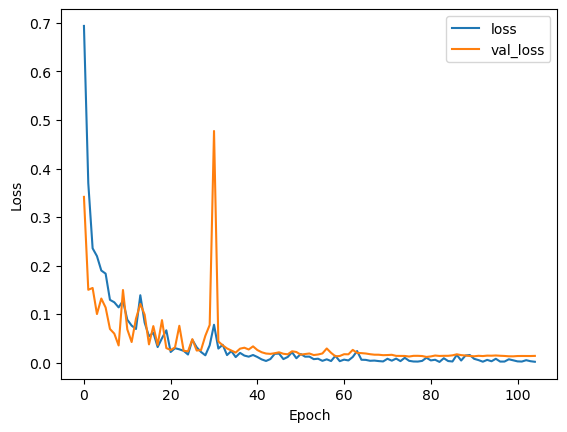

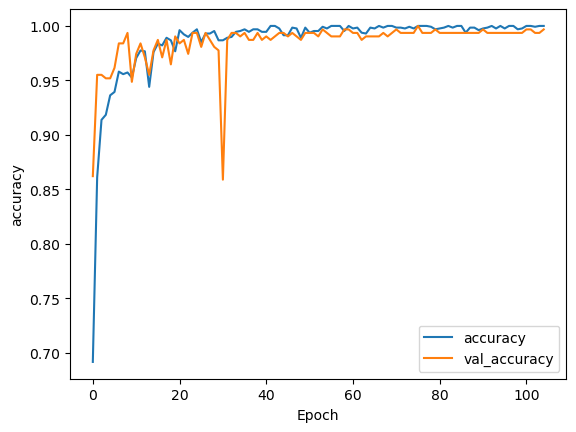

CPU times: user 6h 27min 17s, sys: 19min 28s, total: 6h 46min 45s
Wall time: 5h 44min 43s


In [16]:
%%time

x_train, y_train, type_train, x_valid, y_valid, type_valid , classes_dict = split_data_train_valid(images_df,
                                                                                                   target_name,
                                                                                                   classes_list,
                                                                                                   conditions_dict)

params_train = {'dim': input_shape[:2],
                'batch_size': batch_size,
                'n_channels': input_shape[-1],
                'n_classes' : nb_classes,
                'shuffle': True,
                'aug': True}

params_valid = {'dim': input_shape[:2],
                'batch_size': batch_size,
                'n_channels': input_shape[-1],
                'n_classes' : nb_classes,
                'shuffle': False,
                'aug': False}

training_generator = my_DataGenerator(x_train, y_train, type_train, **params_train)
validation_generator = my_DataGenerator(x_valid, y_valid, type_valid, **params_valid)

class_weights = compute_class_weights(y_train, nb_classes)

history = model_training(training_generator,
                         validation_generator,
                         input_shape,
                         dropout,
                         output_activation,
                         nb_classes,
                         lr,
                         loss_function,
                         epochs,
                         batch_size,
                         best_model_path,
                         reduce_lr_patience,
                         early_stopping_patience,
                         class_weights)

plot_training_history(history)

CPU times: user 59.1 s, sys: 1.71 s, total: 1min
Wall time: 1min 8s


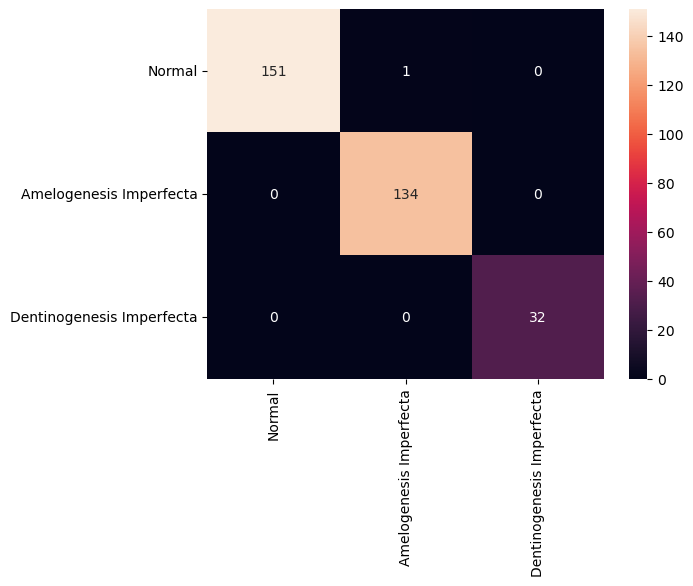

In [17]:
%%time

cohort_predictions = model_evaluation(best_model_path,
                                      x_valid,
                                      y_valid,
                                      classes_list,
                                      input_shape,
                                      plot_wrong_predicitons = False,
                                      plot_confusion_matrix = True,
                                      plot_shap_predictions = False)

In [18]:
tf.keras.backend.clear_session()
reset_random_seeds()

In [19]:
target_name = 'AI_Type'
classes_list = ['AI_Hypomature',
                'AI_Hypoplastic',
                'AI_Hypocalcification/Hypomineralization',
                'AI_Hypomature/AI_Hypoplastic/Taurodontism']
conditions_dict = {}

input_shape = (512, 512, 3) # we found that training with a bigger image gives slightly better results
dropout = 0.2 # to reduce overfitting
output_activation = 'sigmoid'
nb_classes = len(classes_list)
lr = 0.00008 # Since we're using transfer learning, the learning rate is set to a low value to not lose the knowledge of the pretrained model
loss_function = 'binary_crossentropy' # depends on the output_activation
epochs = 150 
batch_size = 8 # limited by the GPU memory. We could get better results with a higher value.
best_model_path = './ai_type_model.h5'
reduce_lr_patience = 6
early_stopping_patience = 25


Epoch 1/150
67/67 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.1903 - f1_score: 0.1911
Epoch 1: val_loss improved from inf to 0.78408, saving model to ./ai_type_model.h5
67/67 [==============================] - 145s 1s/step - loss: 0.6356 - accuracy: 0.1903 - f1_score: 0.1911 - val_loss: 0.7841 - val_accuracy: 0.1562 - val_f1_score: 0.0773 - lr: 8.0000e-05
Epoch 2/150
67/67 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.3433 - f1_score: 0.3355
Epoch 2: val_loss improved from 0.78408 to 0.59748, saving model to ./ai_type_model.h5
67/67 [==============================] - 86s 1s/step - loss: 0.5190 - accuracy: 0.3433 - f1_score: 0.3355 - val_loss: 0.5975 - val_accuracy: 0.3828 - val_f1_score: 0.3089 - lr: 8.0000e-05
Epoch 3/150
67/67 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.4515 - f1_score: 0.4380
Epoch 3: val_loss improved from 0.59748 to 0.48888, saving model to ./ai_type_model.h5
67/67 [=================

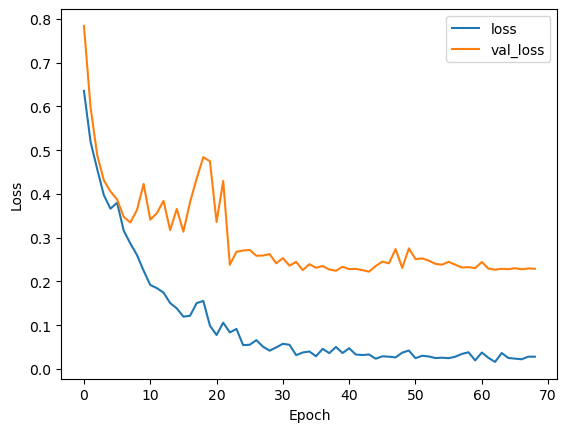

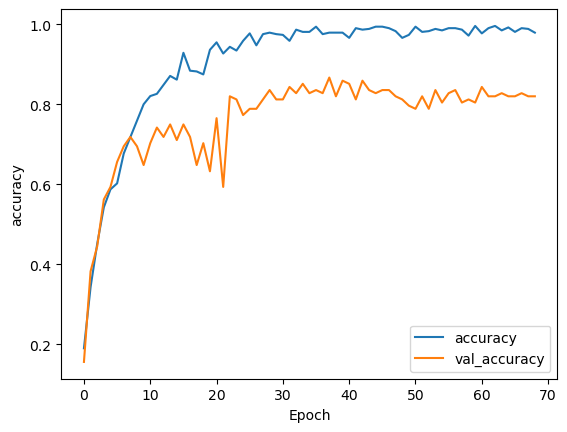

CPU times: user 2h 40s, sys: 5min 44s, total: 2h 6min 24s
Wall time: 1h 39min


In [20]:
%%time

x_train, y_train, type_train, x_valid, y_valid, type_valid , classes_dict = split_data_train_valid(images_df,
                                                                                                   target_name,
                                                                                                   classes_list,
                                                                                                   conditions_dict)

params_train = {'dim': input_shape[:2],
                'batch_size': batch_size,
                'n_channels': input_shape[-1],
                'n_classes' : nb_classes,
                'shuffle': True,
                'aug': True}

params_valid = {'dim': input_shape[:2],
                'batch_size': batch_size,
                'n_channels': input_shape[-1],
                'n_classes' : nb_classes,
                'shuffle': False,
                'aug': False}

training_generator = my_DataGenerator(x_train, y_train, type_train, **params_train)
validation_generator = my_DataGenerator(x_valid, y_valid, type_valid, **params_valid)

class_weights = compute_class_weights(y_train, nb_classes)

history = model_training(training_generator,
                         validation_generator,
                         input_shape,
                         dropout,
                         output_activation,
                         nb_classes,
                         lr,
                         loss_function,
                         epochs,
                         batch_size,
                         best_model_path,
                         reduce_lr_patience,
                         early_stopping_patience,
                         class_weights)

plot_training_history(history)

CPU times: user 31.2 s, sys: 817 ms, total: 32 s
Wall time: 34.8 s


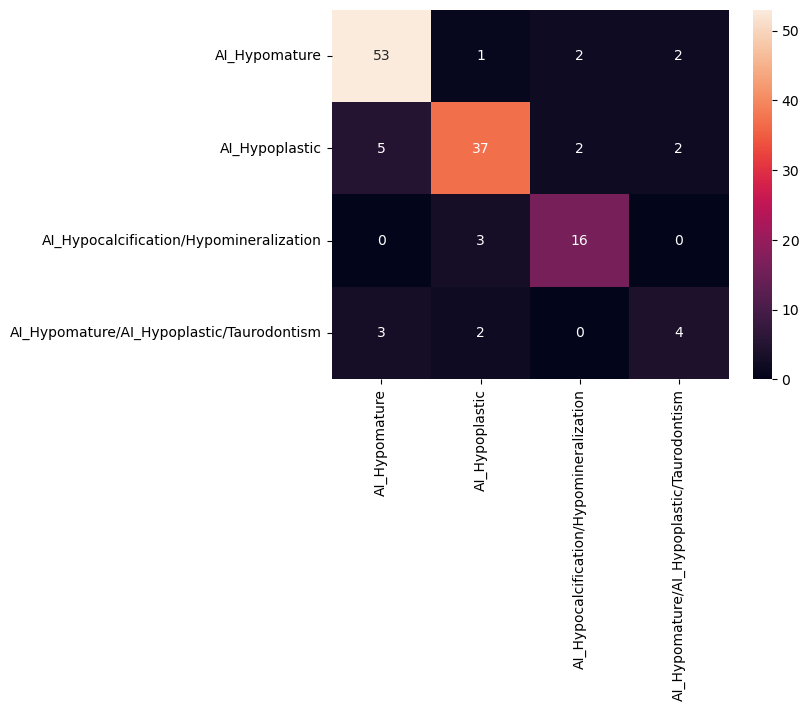

In [21]:
%%time

ai_type_predictions = model_evaluation(best_model_path,
                                       x_valid,
                                       y_valid,
                                       classes_list,
                                       input_shape,
                                       plot_wrong_predicitons = False,
                                       plot_confusion_matrix = True,
                                       plot_shap_predictions = False)

In [22]:
tf.keras.backend.clear_session()
reset_random_seeds()

In [23]:
target_name = 'Is_Isolated_Syndromic'
classes_list = ['None', 'Isolated', 'Syndromic']
conditions_dict = {'Cohort': 'Amelogenesis Imperfecta'}

input_shape = (512, 512, 3) # we found that training with a bigger image gives slightly better results
dropout = 0.5 # to reduce overfitting
output_activation = 'sigmoid'
nb_classes = len(classes_list)
lr = 0.00008 # Since we're using transfer learning, the learning rate is set to a low value to not lose the knowledge of the pretrained model
loss_function = 'binary_crossentropy' # depends on the output_activation
epochs = 150 
batch_size = 8 # limited by the GPU memory. We could get better results with a higher value.
best_model_path = './is_isolated_syndromic_model.h5'
reduce_lr_patience = 7
early_stopping_patience = 25


Epoch 1/150
67/67 [==============================] - ETA: 0s - loss: 0.7806 - accuracy: 0.2724 - f1_score: 0.2801
Epoch 1: val_loss improved from inf to 0.86599, saving model to ./is_isolated_syndromic_model.h5
67/67 [==============================] - 142s 1s/step - loss: 0.7806 - accuracy: 0.2724 - f1_score: 0.2801 - val_loss: 0.8660 - val_accuracy: 0.2031 - val_f1_score: 0.1583 - lr: 8.0000e-05
Epoch 2/150
67/67 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.4664 - f1_score: 0.4536
Epoch 2: val_loss did not improve from 0.86599
67/67 [==============================] - 83s 1s/step - loss: 0.6317 - accuracy: 0.4664 - f1_score: 0.4536 - val_loss: 0.9055 - val_accuracy: 0.1875 - val_f1_score: 0.1447 - lr: 8.0000e-05
Epoch 3/150
67/67 [==============================] - ETA: 0s - loss: 0.5494 - accuracy: 0.5522 - f1_score: 0.5475
Epoch 3: val_loss improved from 0.86599 to 0.69141, saving model to ./is_isolated_syndromic_model.h5
67/67 [=============================

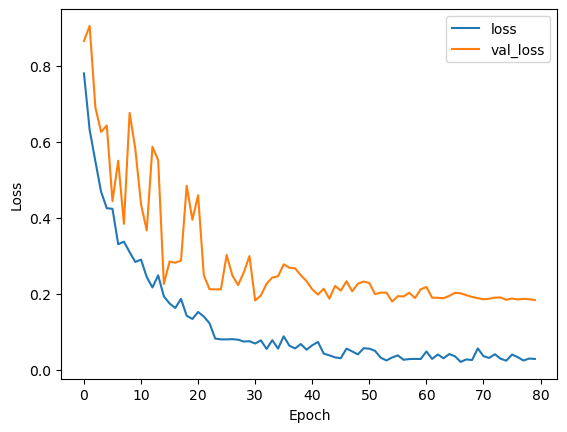

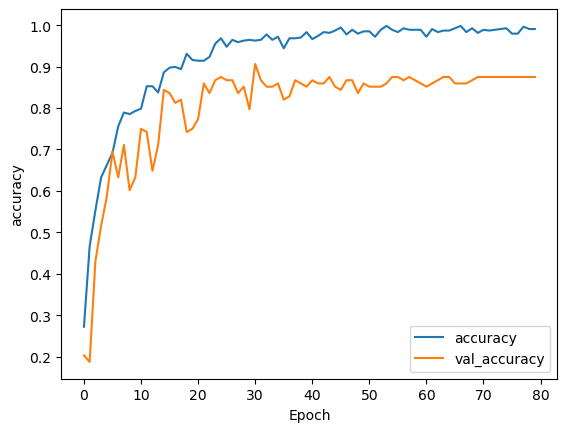

CPU times: user 2h 19min 28s, sys: 6min 41s, total: 2h 26min 9s
Wall time: 1h 53min 11s


In [24]:
%%time

x_train, y_train, type_train, x_valid, y_valid, type_valid , classes_dict = split_data_train_valid(images_df,
                                                                                                   target_name,
                                                                                                   classes_list,
                                                                                                   conditions_dict)

params_train = {'dim': input_shape[:2],
                'batch_size': batch_size,
                'n_channels': input_shape[-1],
                'n_classes' : nb_classes,
                'shuffle': True,
                'aug': True}

params_valid = {'dim': input_shape[:2],
                'batch_size': batch_size,
                'n_channels': input_shape[-1],
                'n_classes' : nb_classes,
                'shuffle': False,
                'aug': False}

training_generator = my_DataGenerator(x_train, y_train, type_train, **params_train)
validation_generator = my_DataGenerator(x_valid, y_valid, type_valid, **params_valid)

class_weights = compute_class_weights(y_train, nb_classes)

history = model_training(training_generator,
                         validation_generator,
                         input_shape,
                         dropout,
                         output_activation,
                         nb_classes,
                         lr,
                         loss_function,
                         epochs,
                         batch_size,
                         best_model_path,
                         reduce_lr_patience,
                         early_stopping_patience,
                         class_weights)

plot_training_history(history)

CPU times: user 29.9 s, sys: 617 ms, total: 30.5 s
Wall time: 33.1 s


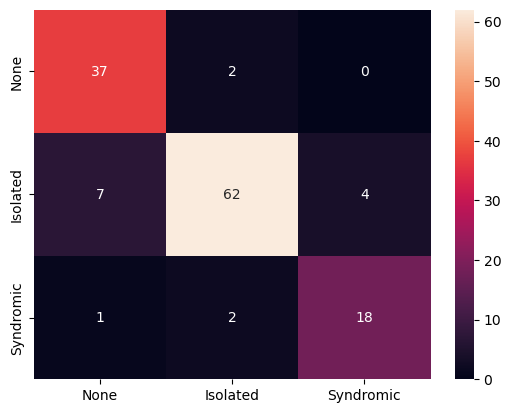

In [25]:
%%time

is_isolated_syndromic_predictions = model_evaluation(best_model_path,
                                                     x_valid,
                                                     y_valid,
                                                     classes_list,
                                                     input_shape,
                                                     plot_wrong_predicitons = False,
                                                     plot_confusion_matrix = True,
                                                     plot_shap_predictions = False)

In [26]:
tf.keras.backend.clear_session()
reset_random_seeds()

In [27]:
target_name = 'Responsible_Gene_Name'
classes_list = ['AMELX', 'ENAM', 'COL17A1', 'COL7A1']
conditions_dict = {'Cohort': 'Amelogenesis Imperfecta',
                   'AI_Type': 'AI_Hypoplastic',
                   'Is_Isolated_Syndromic': 'Isolated'}

input_shape = (512, 512, 3) # we found that training with a bigger image gives slightly better results
dropout = 0.3 # to reduce overfitting
output_activation = 'sigmoid'
nb_classes = len(classes_list)
lr = 0.00008 # Since we're using transfer learning, the learning rate is set to a low value to not lose the knowledge of the pretrained model
loss_function = 'binary_crossentropy' # depends on the output_activation
epochs = 150 
batch_size = 4 # limited by the GPU memory. We could get better results with a higher value.
best_model_path = './responsible_gene_name_model.h5'
reduce_lr_patience = 6
early_stopping_patience = 25


Epoch 1/150
20/20 [==============================] - ETA: 0s - loss: 0.7607 - accuracy: 0.2375 - f1_score: 0.2028
Epoch 1: val_loss improved from inf to 0.86114, saving model to ./responsible_gene_name_model.h5
20/20 [==============================] - 82s 875ms/step - loss: 0.7607 - accuracy: 0.2375 - f1_score: 0.2028 - val_loss: 0.8611 - val_accuracy: 0.2500 - val_f1_score: 0.1625 - lr: 8.0000e-05
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 0.6054 - accuracy: 0.3875 - f1_score: 0.3308
Epoch 2: val_loss improved from 0.86114 to 0.84082, saving model to ./responsible_gene_name_model.h5
20/20 [==============================] - 15s 717ms/step - loss: 0.6054 - accuracy: 0.3875 - f1_score: 0.3308 - val_loss: 0.8408 - val_accuracy: 0.3333 - val_f1_score: 0.2154 - lr: 8.0000e-05
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.5125 - f1_score: 0.4954
Epoch 3: val_loss improved from 0.84082 to 0.71978, saving model to ./responsi

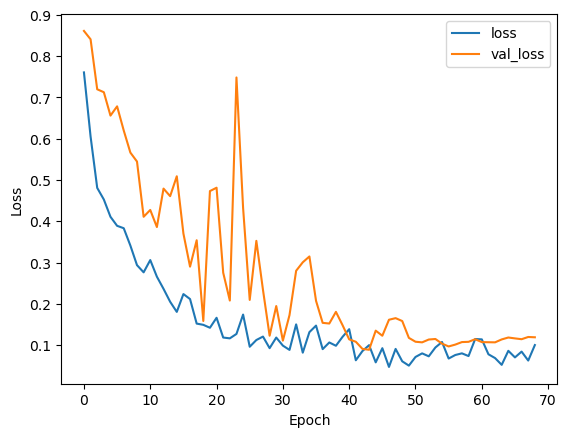

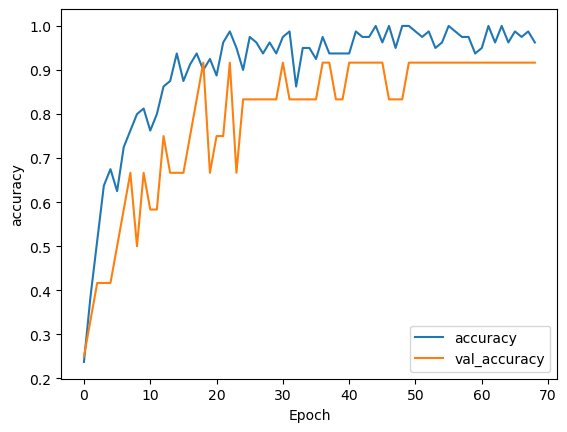

CPU times: user 21min 18s, sys: 1min 1s, total: 22min 20s
Wall time: 16min 48s


In [28]:
%%time

x_train, y_train, type_train, x_valid, y_valid, type_valid , classes_dict = split_data_train_valid(images_df,
                                                                                                   target_name,
                                                                                                   classes_list,
                                                                                                   conditions_dict)

params_train = {'dim': input_shape[:2],
                'batch_size': batch_size,
                'n_channels': input_shape[-1],
                'n_classes' : nb_classes,
                'shuffle': True,
                'aug': True}

params_valid = {'dim': input_shape[:2],
                'batch_size': batch_size,
                'n_channels': input_shape[-1],
                'n_classes' : nb_classes,
                'shuffle': False,
                'aug': False}

training_generator = my_DataGenerator(x_train, y_train, type_train, **params_train)
validation_generator = my_DataGenerator(x_valid, y_valid, type_valid, **params_valid)

class_weights = compute_class_weights(y_train, nb_classes)

history = model_training(training_generator,
                         validation_generator,
                         input_shape,
                         dropout,
                         output_activation,
                         nb_classes,
                         lr,
                         loss_function,
                         epochs,
                         batch_size,
                         best_model_path,
                         reduce_lr_patience,
                         early_stopping_patience,
                         class_weights)

plot_training_history(history)

CPU times: user 8.22 s, sys: 201 ms, total: 8.42 s
Wall time: 8.65 s


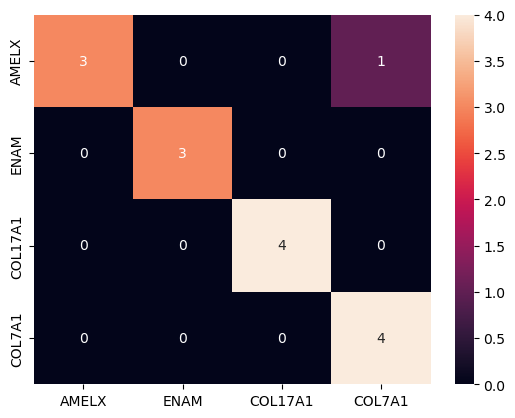

In [29]:
%%time

responsible_gene_name_predictions = model_evaluation(best_model_path,
                                                     x_valid,
                                                     y_valid,
                                                     classes_list,
                                                     input_shape,
                                                     plot_wrong_predicitons = False,
                                                     plot_confusion_matrix = True,
                                                     plot_shap_predictions = False)

In [30]:
test_df = pd.read_csv('./data/test.csv')

In [31]:
cohort_model = tf.keras.models.load_model('./cohort_model.h5', compile = False)

cohort_classes = ['Normal', 'Amelogenesis Imperfecta', 'Dentinogenesis Imperfecta']

In [32]:
ai_type_model = tf.keras.models.load_model('./ai_type_model.h5', compile = False)

ai_type_classes = ['AI_Hypomature',
                 'AI_Hypoplastic',
                 'AI_Hypocalcification/Hypomineralization',
                 'AI_Hypomature/AI_Hypoplastic/Taurodontism']

In [33]:
is_isolated_syndromic_model = tf.keras.models.load_model('./is_isolated_syndromic_model.h5', compile = False)

is_isolated_syndromic_classes = ['None', 'Isolated', 'Syndromic']

In [34]:
responsible_gene_name_model = tf.keras.models.load_model('./responsible_gene_name_model.h5', compile = False)

responsible_gene_name_classes = ['AMELX', 'ENAM', 'COL17A1', 'COL7A1']

In [35]:
cohort_pred = []
ai_type_pred = []
Responsible_Gene_Name_pred = []
Is_Isolated_Syndromic_pred = []
patient_id_list = test_df['Patient_ID'].tolist()
for patient_id in patient_id_list:
    all_imgs = images_df.loc[images_df['Patient_ID'] == patient_id]['Image_ID'].tolist()
    input_images = []
    for img_name in all_imgs:
        img = cv2.imread('./data/images/'+img_name)
        img = img[:,:,0:3]
        img = cv2.resize(img, (512,512))
        img_p = img.astype('float32')
        img_p = img_p/255.
        input_images.append(np.expand_dims(img_p, 0))
    
    preds_cohort = []
    for i in range(len(input_images)):
        preds_cohort.append(cohort_model.predict(input_images[i], verbose=0)[0])
    pred_class = np.argmax(np.mean(np.array(preds_cohort), axis=0))
    cohort_pred.append(cohort_classes[pred_class])
    if pred_class == 0:
        ai_type_pred.append('None')
        Responsible_Gene_Name_pred.append('None')
        Is_Isolated_Syndromic_pred.append('None')
    elif pred_class == 2:
        ai_type_pred.append('None')
        Responsible_Gene_Name_pred.append('None')
        Is_Isolated_Syndromic_pred.append('Isolated')
    elif pred_class == 1:
        preds_aitype = []
        preds_isosynd_all = []
        for i in range(len(input_images)):
            preds_aitype.append(ai_type_model.predict(input_images[i], verbose=0)[0])
            preds_isosynd_all.append(is_isolated_syndromic_model.predict(input_images[i], verbose=0)[0])
        pred_class_aitype = np.argmax(np.mean(np.array(preds_aitype), axis=0))
        pred_class_isosynd_all = np.argmax(np.mean(np.array(preds_isosynd_all), axis=0))
        ai_type_pred.append(ai_type_classes[pred_class_aitype])
        Is_Isolated_Syndromic_pred.append(is_isolated_syndromic_classes[pred_class_isosynd_all])
        if pred_class_isosynd_all == 0:
                Responsible_Gene_Name_pred.append('None')
        else:
            if pred_class_aitype == 0:
                if pred_class_isosynd_all == 1:
                    Responsible_Gene_Name_pred.append('MMP20')
                elif pred_class_isosynd_all == 2:
                    Responsible_Gene_Name_pred.append('SLC10A7')
            elif pred_class_aitype == 1:
                if pred_class_isosynd_all == 1:
                    preds_gene = []
                    for i in range(len(input_images)):
                        preds_gene.append(responsible_gene_name_model.predict(input_images[i], verbose=0)[0])
                    pred_class_gene = np.argmax(np.mean(np.array(preds_gene), axis=0))
                    Responsible_Gene_Name_pred.append(responsible_gene_name_classes[pred_class_gene])
                elif pred_class_isosynd_all == 2:
                    Responsible_Gene_Name_pred.append('FAM20A')
            elif pred_class_aitype == 2:
                if pred_class_isosynd_all == 1:
                    Responsible_Gene_Name_pred.append('FAM83H')
                elif pred_class_isosynd_all == 2:
                    Responsible_Gene_Name_pred.append('CNNM4')
            elif pred_class_aitype == 3:
                Responsible_Gene_Name_pred.append('DLX3')
                
test_df['Cohort'] = cohort_pred
test_df['AI_Type'] = ai_type_pred
test_df['Responsible_Gene_Name'] = Responsible_Gene_Name_pred
test_df['Is_Isolated_Syndromic'] = Is_Isolated_Syndromic_pred

test_df.to_csv('./submission.csv', index=False, encoding='UTF-8')

In [36]:
submitted_df = pd.read_csv("./7100.csv")
computed_df = pd.read_csv("./submission.csv")

In [39]:
diff_df = submitted_df.compare(computed_df)

In [48]:
diff_df["AI_Type"].notnull().sum()

self     9
other    9
dtype: int64

In [54]:
7/computed_df.shape[0]

0.06363636363636363

In [52]:
diff_df["Responsible_Gene_Name"].notnull().sum()

self     17
other    17
dtype: int64

In [51]:
diff_df["Is_Isolated_Syndromic"].notnull().sum()

self     7
other    7
dtype: int64

In [ ]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf

In [ ]:
%cd ..

In [ ]:
test_df = pd.read_csv('data/test.csv')
images_df = pd.read_csv('data/images.csv')

In [ ]:
model_cohort = tf.keras.models.load_model('./logs/new_1/seed4_512_cohort_ep052-loss0.012-val_loss0.018-val_acc0.997-val_f1s0.998.h5',
                                             compile = False)

In [ ]:
model_aitype = tf.keras.models.load_model('./logs/new_1/sig_seed4_512_aitype_ep063-loss0.014-val_loss0.225-val_acc0.828-val_f1s0.770.h5',
                                             compile = False)

In [ ]:
model_isosynd_all = tf.keras.models.load_model('./logs/new_1/seed4_512_isosynd_all_ep046-loss0.026-val_loss0.195-val_acc0.955-val_f1s0.924.h5',
                                             compile = False)

In [ ]:
model_gene = tf.keras.models.load_model('./logs/new_1/4c_seed4_512_gene_ep046-loss0.345-val_loss0.126-val_acc1.000-val_f1s1.000.h5',
                                             compile = False)

In [ ]:
classes_cohort = ['Normal', 'Amelogenesis Imperfecta', 'Dentinogenesis Imperfecta']

In [ ]:
classes_aitype = ['AI_Hypomature',
                 'AI_Hypoplastic',
                 'AI_Hypocalcification/Hypomineralization',
                 'AI_Hypomature/AI_Hypoplastic/Taurodontism']

In [ ]:
classes_isosynd_all = ['None', 'Isolated', 'Syndromic']

In [ ]:
classes_gene = ['AMELX', 'ENAM', 'COL17A1', 'COL7A1']

In [ ]:
cohort_pred = []
ai_type_pred = []
Responsible_Gene_Name_pred = []
Is_Isolated_Syndromic_pred = []
patient_id_list = test_df['Patient_ID'].tolist()
for patient_id in patient_id_list:
    all_imgs = images_df.loc[images_df['Patient_ID'] == patient_id]['Image_ID'].tolist()
    # print('nb images: ', len(all_imgs))
    preds_cohort = []
    for img_name in all_imgs:
        img = cv2.imread('../data/images/'+img_name)
        img = img[:,:,0:3]
        img = cv2.resize(img, (512,512))
        img_p = img.astype('float32')
        img_p = img_p/255.
        img_p = np.expand_dims(img_p, 0)
        preds_cohort.append(model_cohort.predict(img_p, verbose=0)[0])
    pred_class = np.argmax(np.mean(np.array(preds_cohort), axis=0))
    cohort_pred.append(classes_cohort[pred_class])
    if pred_class == 0:
        ai_type_pred.append('None')
        Responsible_Gene_Name_pred.append('None')
        Is_Isolated_Syndromic_pred.append('None')
    elif pred_class == 2:
        ai_type_pred.append('None')
        Responsible_Gene_Name_pred.append('None')
        Is_Isolated_Syndromic_pred.append('Isolated')
    elif pred_class == 1:
        preds_aitype = []
        preds_isosynd_all = []
        for img_name in all_imgs:
            img = cv2.imread('../data/images/'+img_name)
            img = img[:,:,0:3]
            img = cv2.resize(img, (512,512))
            img_p = img.astype('float32')
            img_p = img_p/255.
            img_p = np.expand_dims(img_p, 0)
            preds_aitype.append(model_aitype.predict(img_p, verbose=0)[0])
            preds_isosynd_all.append(model_isosynd_all.predict(img_p, verbose=0)[0])
        pred_class_aitype = np.argmax(np.mean(np.array(preds_aitype), axis=0))
        pred_class_isosynd_all = np.argmax(np.mean(np.array(preds_isosynd_all), axis=0))
        ai_type_pred.append(classes_aitype[pred_class_aitype])
        Is_Isolated_Syndromic_pred.append(classes_isosynd_all[pred_class_isosynd_all])
        if pred_class_isosynd_all == 0:
                Responsible_Gene_Name_pred.append('None')
        else:
            if pred_class_aitype == 0:
                if pred_class_isosynd_all == 1:
                    Responsible_Gene_Name_pred.append('MMP20')
                elif pred_class_isosynd_all == 2:
                    Responsible_Gene_Name_pred.append('SLC10A7')
            elif pred_class_aitype == 1:
                if pred_class_isosynd_all == 1:
                    preds_gene = []
                    for img_name in all_imgs:
                        img = cv2.imread('../data/images/'+img_name)
                        img = img[:,:,0:3]
                        img = cv2.resize(img, (512,512))
                        img_p = img.astype('float32')
                        img_p = img_p/255.
                        img_p = np.expand_dims(img_p, 0)
                        preds_gene.append(model_gene.predict(img_p, verbose=0)[0])
                    pred_class_gene = np.argmax(np.mean(np.array(preds_gene), axis=0))
                    Responsible_Gene_Name_pred.append(classes_gene[pred_class_gene])
                elif pred_class_isosynd_all == 2:
                    Responsible_Gene_Name_pred.append('FAM20A')
            elif pred_class_aitype == 2:
                if pred_class_isosynd_all == 1:
                    Responsible_Gene_Name_pred.append('FAM83H')
                elif pred_class_isosynd_all == 2:
                    Responsible_Gene_Name_pred.append('CNNM4')
            elif pred_class_aitype == 3:
                Responsible_Gene_Name_pred.append('DLX3')

In [ ]:
test_df['Cohort'] = cohort_pred
test_df['AI_Type'] = ai_type_pred
test_df['Responsible_Gene_Name'] = Responsible_Gene_Name_pred
test_df['Is_Isolated_Syndromic'] = Is_Isolated_Syndromic_pred

test_df.to_csv('./submissions/new_1.csv', index=False, encoding='UTF-8')